### Libs imports

In [21]:
# Execute extenttion to reload files in project dir
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:

# Add link to project root
import sys, os
sys.path.append(os.path.abspath('..'))

In [33]:
import pandas as pd
import numpy as np
import requests
from tqdm.notebook import tqdm
from joblib import dump, load
import os
import matplotlib.pyplot as plt

from sklearn import linear_model, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from source.features.super_trend import calculate_supertrend
from source.features.macd import calculate_macd
from source.features.rsi import calculate_rsi
from source.features.obv import calculate_obv_to_volume_ratio
from source.features.bollinger_bands import distance_between_bb_bands
from source.features.chaikin_money_flow import calculate_cmf
from source.features.rate_of_change import calculate_price_rate_of_change, calculate_volume_rate_of_change
from source.features.volume_ratio import calculate_volume_ratio
from source.features.stoch_rsi import calculate_stoch_rsi
from source.features.linear_regression import calculate_trailing_linear_reg_params
from source.prices_source.binance_prices import get_candles_spot_binance

from source.utils import optimal_threshold

from config import MODELS_PATH, PRICES_PATH

### Data Preparation

#### Get Binance data

In [35]:
# Download binance prices
exchange_info = requests.get("https://api.binance.com/api/v3/exchangeInfo").json()
all_symbols = pd.DataFrame(exchange_info['symbols'])

symbols_with_usdt = all_symbols[all_symbols['symbol'].str.contains("USDT")]['symbol'].unique()

# Donwload prices form binance
from tqdm import tqdm_notebook as tqdm
from time import sleep

results = pd.DataFrame({}, columns=["Time", "Open", "High", "Low", "Close", "Volume", "Symbol"]).set_index("Time")

for i, symbol in tqdm(enumerate(symbols_with_usdt[477:])):
    
    try:
        df = get_candles_spot_binance(symbol, "1d", "2018-01-01T10:00:00")
        df.loc[:, "Symbol"] = symbol
        results = pd.concat([results, df])
    except ConnectionError:
        sleep(10)
        df = get_candles_spot_binance(symbol, "1d", "2018-01-01T10:00:00")
        df.loc[:, "Symbol"] = symbol
        results = pd.concat([results, df])
    
results.to_csv(os.path.join(PRICES_PATH, "binance_data.csv"), sep=",")

0it [00:00, ?it/s]

#### Get Moex data

In [36]:
from source.prices_source.moex_prices import get_candles_moex, get_moex_securities

# Download prices from moex
moex_securities = get_moex_securities(engine="stock", market="shares", boards=["TQBR"])

moex_results = pd.DataFrame({}, columns=["Time", "Open", "High", "Low", "Close", "Volume", "Symbol"]).set_index("Time")

for i, ticker in tqdm(enumerate(moex_securities["SECID"])):
    
    try:
        df = get_candles_moex(ticker, 24, "2018-01-01T10:00:00", board="TQBR")
        df.loc[:, "Symbol"] = ticker
        moex_results = pd.concat([moex_results, df])
    except requests.exceptions.ConnectionError as e:
        print(ticker, e)
        continue
    
moex_results.to_csv(os.path.join(PRICES_PATH, "moex_data.csv"), sep=",") 

0it [00:00, ?it/s]

USBN Timeout


##### Data preparation

In [106]:
results = pd.read_csv(os.path.join(PRICES_PATH, "binance_data.csv"), index_col=0, sep=",")
results.index = results.index.map(lambda x: pd.Timestamp(x, tz="Europe/Moscow"))

In [5]:
results = pd.read_csv(os.path.join(PRICES_PATH, "moex_data.csv"), index_col=0, sep=",")
results.index = results.index.map(lambda x: pd.Timestamp(x, tz="Europe/Moscow"))

In [95]:
from source.prices_source.binance_prices import get_candles_spot_binance
from source.utils import normalize_prices

from source.features.super_trend import calculate_supertrend
from source.features.macd import calculate_macd
from source.features.rsi import calculate_rsi
from source.features.obv import calculate_obv_to_volume_ratio
from source.features.bollinger_bands import distance_between_bb_bands
from source.features.chaikin_money_flow import calculate_cmf
from source.features.rate_of_change import calculate_price_rate_of_change, calculate_volume_rate_of_change
from source.features.volume_ratio import calculate_volume_ratio
from source.features.stoch_rsi import calculate_stoch_rsi
from source.features.linear_regression import calculate_trailing_linear_reg_params

# Features
##############
features = {
    "calculate_supertrend": [["SuperTrend"], {"vol_func": "atr", "lookback": 20, "multiplier": 2.5}],
    "calculate_macd": [["MACD_Signal_Line", "MACD", "MACD_Bar_Charts"], {"short_period": 12, "long_period": 26, "smoothing_period": 9}],
    "calculate_rsi": [["RSI"], {"period": 20, "ema": True}],
    "calculate_obv_to_volume_ratio": [["OBV_Volume_Ratio"], {}],
    "distance_between_bb_bands": [["Upper_distance", "Lower_distance"], {"period": 20, "multiplier": 2.5, "ema": 2.5, "normalize": True}],
    "calculate_cmf": [["CMF"], {"period": 20}],
    "calculate_price_rate_of_change": [["Price_ROC"], {}],
    "calculate_volume_rate_of_change": [["Volume_ROC"], {}],
    "calculate_volume_ratio": [["Volume_Ratio"], {"period": 20, "ema": True}],
    "calculate_stoch_rsi": [["Stoch_RSI_K", "Stoch_RSI_D"], {"rsi_period": 20, "k_period": 20, "smooth_k": 5, "smooth_k": 5, "ema": True}],
    "calculate_trailing_linear_reg_params": [["Reg_Coef", "RMSE"], {"period": 25, "col_name": "cum_prod"}]
}

feature_cols = sum(list(map(lambda x: x[0], features.values())), [])
###############

# Strategy params 
##################
strategy_params = {
    "last_features_window": 7,
    "candles_between_pump": 30,
    "validation_window": 10, # candles
    "min_yield": -20, # %
    "max_yield": 20,
    "first_yield": 3
}
##################

data_set = pd.DataFrame({})

symbols = results["Symbol"].unique()

for symbol in tqdm(symbols):
    
    # Get sample of prices by ticker
    sample = results[results["Symbol"] == symbol]
    
    # Nomalize prices with beggining 100
    # Drop first element to avoid mistakes
    sample.loc[:, ["High", "Low", "Close", "Open"]] = sample.loc[:, ["High", "Low", "Close", "Open"]].apply(normalize_prices)
    sample = sample.iloc[1:]
    
    # Skip if len of prices < time between pump
    if len(sample) < strategy_params["candles_between_pump"]:
        continue

    # Calculate trailing cumulative yield over specified rolling window
    # Calculate yield at 1 day before cumulative yield. In other words yield_before_pump is not included in calculation of cum_prod, yield_before_pump == before pump date
    sample.loc[:, "cum_prod"] = sample["Close"].pct_change().add(1).rolling(window=strategy_params["validation_window"]).apply(np.prod).subtract(1).multiply(100).fillna(0).values
    sample.loc[:, "yield_before_pump"] = sample["Close"].pct_change().multiply(100).shift(strategy_params["validation_window"])

    # Calculate features. Feature functions update original DataFrame
    for feature, values in features.items():
        eval(feature)(sample, **values[1])
    
    feature_df = sample[feature_cols].bfill()
    
    # Define pumps
    outliers_values = sample[(sample["cum_prod"] >= strategy_params["max_yield"]) & (sample["yield_before_pump"] >= strategy_params["first_yield"])]
    
    # For diluting data
    other_values_first = sample[(sample["cum_prod"] < strategy_params["max_yield"]) & (sample["cum_prod"] > 0) & (sample["yield_before_pump"] >= strategy_params["first_yield"])]
    other_values_second = sample[(sample["cum_prod"] < 0) & (sample["yield_before_pump"] >= strategy_params["first_yield"])]
    other_values_third = sample[(sample["yield_before_pump"] < strategy_params["first_yield"])]


    if outliers_values.empty:
        continue
    
    # Filter pumps by appropriate num of candles between pumps
    last_dt = sample.index[0]
    for dt in outliers_values.index:
        outliers_values.loc[dt, "candles_delta"] = len(sample.loc[last_dt:dt])
        last_dt = dt
        
    outliers_values = outliers_values[outliers_values["candles_delta"] >= strategy_params["candles_between_pump"]]

    # Update dataset for model
    for date in outliers_values.index:
        
        before_pump_date = sample.iloc[sample.index.get_loc(date) - (strategy_params["validation_window"])].name # 1 Day before pump
        
        summary_dct = {
            'symbol': symbol,
            'before_pump_date': before_pump_date,
            'data_type': ">5>15",
            'class': 1
        }
        
        last_features = feature_df.loc[:before_pump_date].iloc[-strategy_params["last_features_window"]:]

        for name, values in last_features.items():
            for i, value in enumerate(values):
                summary_dct[name + "_" + str(i)] = value

        summary = pd.DataFrame(summary_dct, index=[len(data_set) + 1])

        data_set = pd.concat([data_set, summary])
        
    for sample_numb, data_name, other_values in [[4, ">5>0<15", other_values_first], [2, ">5<0", other_values_second], [2, "<0", other_values_third]]:
        
        for date in other_values.sample(frac=1).head(sample_numb).index:
            
            before_pump_date = sample.iloc[sample.index.get_loc(date) - (strategy_params["validation_window"])].name # 1 Day before pump

            summary_dct = {
                'symbol': symbol,
                'before_pump_date': before_pump_date,
                'data_type': data_name,
                'class': 0
            }

            last_features = feature_df.loc[:before_pump_date].iloc[-strategy_params["last_features_window"]:]

            for name, values in last_features.items():
                for i, value in enumerate(values):
                    summary_dct[name + "_" + str(i)] = value

            summary = pd.DataFrame(summary_dct, index=[len(data_set) + 1])

            data_set = pd.concat([data_set, summary])
    
    print(np.where(symbols == symbol)[0][0])
    # except:
    #     continue

  0%|          | 0/478 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9
11
12
13
14
15
16
18
19
21
22
24
25
26
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
96
97
98
99
100
101
102
103
104
105
106
107
109
110
111
112
113
114
115
118
119
120
121
122
123
125
126
127
128
129
130
131
132
133
134
135
136
137
138
140
143
144
145
146
147
148
149
150
151
152
153
155
156
158
159
160
161
162
163
165
167
168
169
170
171
173
174
175
176
177
178
179
180
181
182
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
249
250
251
252
253
254
255
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
29

In [110]:
import xgboost as xgb

data_set = data_set.dropna()
data_set = data_set[np.all(data_set != np.inf, axis=1)]
feature_names = data_set.drop(["symbol", "before_pump_date", "class", "data_type"], axis=1).columns

X_train, X_test, y_train, y_test = train_test_split(data_set.loc[:, feature_names], data_set.loc[:, 'class'].astype('int'), 
                                                    test_size = 0.2, shuffle=True)



# xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42) # squarederror

# params = {
#     "colsample_bytree": [0.7, 0.3],
#     "gamma": [0, 0.5],
#     "learning_rate": [0.1, 0.03, 0.3], # default 0.1 
#     "max_depth": [2, 6], # default 3
#     "n_estimators": [100, 300], # default 100
#     "subsample": [0.6, 0.4]
# }

# kfold = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)

# model = GridSearchCV(xgb_model, 
#                      param_grid=params,
#                      cv=kfold,
#                      verbose=1,
#                      n_jobs=6)


# model.fit(X_train, y_train)

model = load(os.path.join(MODELS_PATH, "xgb_model.joblib"))

# # Common way
# predict = model.best_estimator_.predict(X_test)

#Proba
predict_proba = model.best_estimator_.predict_proba(X_test)
rate, _ = optimal_threshold(predict_proba[:, 1])
predict = predict_proba[:, 1] >= rate * 1
print(rate)


print(classification_report(y_test, predict))
print("accuracy: ", accuracy_score(y_test, predict))
print(confusion_matrix(y_test, predict))

# dump(model, os.path.join(MODELS_PATH, "xgb_model.joblib"))

0.39169663
              precision    recall  f1-score   support

           0       0.93      0.68      0.78       668
           1       0.70      0.94      0.80       548

    accuracy                           0.79      1216
   macro avg       0.82      0.81      0.79      1216
weighted avg       0.83      0.79      0.79      1216

accuracy:  0.7935855263157895
[[452 216]
 [ 35 513]]


In [14]:
p = {1: 1, 2: 2, 3: 3}
x = {4: 4, 5: 5, 6: 6}

p.update(x)

In [15]:
sum()

{1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}

In [477]:
roll_window = 2 # candles
min_yield = -15 # %
time_between_pump = 0
candles_for_lin_reg = 25

max_yield = 15

# data_set = pd.DataFrame({}, columns=["symbol", "pump_date", "reg_coef", "rmse", "class"])

symbols = results["Symbol"].unique()

for symbol in symbols:
    
    sample = results[results["Symbol"] == symbol]
    break
    sample.loc[:, "cum_prod"] = sample["Close"].pct_change().add(1).rolling(window=roll_window).apply(np.prod).subtract(1).multiply(100).values
    cum_prod = sample[(sample["cum_prod"] >= min_yield) & (sample["cum_prod"] <= max_yield)]
    
    if cum_prod.empty:
        continue
        
    cum_prod.loc[:, "time_delta"] = cum_prod.reset_index().Time.diff().apply(lambda x: x.days).fillna(10e5).values
    cum_prod = cum_prod[cum_prod["time_delta"] >= time_between_pump]
    
    for date in cum_prod.sample(frac=1).head(10).index:
        pump_date = date - pd.Timedelta(days=roll_window-1)
        observations = sample.loc[:date].iloc[-candles_for_lin_reg:]

        yld = [100]
        for i in observations["Close"].pct_change().iloc[1:]:
            yld.append(yld[-1] * (i + 1))

        observations.loc[:, "cum_yield"] = yld

        reg_coef, rmse = get_linear_features(observations, roll_window)
        
        summary = pd.DataFrame(
            {
                'symbol': symbol,
                'pump_date': pump_date,
                'reg_coef': reg_coef,
                'rmse': rmse,
                'class': 0
            }, index=[len(data_set) + 1]
        )
        
        data_set = pd.concat([data_set, summary])
        

In [102]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

data_set = data_set.dropna()
data_set = data_set[np.all(data_set != np.inf, axis=1)]
feature_names = data_set.drop(["symbol", "pump_date", "class", "data_type"], axis=1).columns
    
kf = KFold(n_splits=5, shuffle=True)
for train, test in kf.split(data_set):
    
    print(len(train), len(test))
    
    X_train, y_train = data_set.iloc[train].loc[:, feature_names], data_set.iloc[train]['class'].astype('int')
    X_test, y_test = data_set.iloc[test].loc[:, feature_names], data_set.iloc[test]['class'].astype('int')
    print(y_train.value_counts(), "\n", y_test.value_counts())

    from sklearn.ensemble import GradientBoostingClassifier
    rf_params = {
            'loss' : ["deviance"],
            'n_estimators' : [100, 200, 300],
            'learning_rate': [0.1, 0.05, 0.01],
            'max_depth': [4, 8],
            'min_samples_leaf': [100, 150],
            'max_features': [0.3, 0.1]
    }

    kfold = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)

    gb_model = GridSearchCV(GradientBoostingClassifier(),
                        param_grid=rf_params,
                        cv=kfold,
                        n_jobs=6,
                        scoring="roc_auc",
                        verbose=1,
                        )

    gb_model.fit(X_train, y_train)


    predict = gb_model.best_estimator_.predict(X_test)
    # predict_proba = random_forest_model.best_estimator_.predict_proba(X_test)

    # rate, _ = optimal_threshold(predict_proba[:, 1])

    # print(rate)
    print(classification_report(y_test, predict))
    print("accuracy: ", accuracy_score(y_test, predict))
    print(confusion_matrix(y_test, predict))
    print("\n\n\n")

4208 1052
0    2512
1    1696
Name: class, dtype: int64 
 0    653
1    399
Name: class, dtype: int64
Fitting 5 folds for each of 72 candidates, totalling 360 fits
              precision    recall  f1-score   support

           0       0.73      0.75      0.74       653
           1       0.57      0.53      0.55       399

    accuracy                           0.67      1052
   macro avg       0.65      0.64      0.65      1052
weighted avg       0.67      0.67      0.67      1052

accuracy:  0.6711026615969582
[[493 160]
 [186 213]]




4208 1052
0    2526
1    1682
Name: class, dtype: int64 
 0    639
1    413
Name: class, dtype: int64
Fitting 5 folds for each of 72 candidates, totalling 360 fits
              precision    recall  f1-score   support

           0       0.73      0.77      0.75       639
           1       0.61      0.56      0.59       413

    accuracy                           0.69      1052
   macro avg       0.67      0.67      0.67      1052
weighted avg    

KeyboardInterrupt: 

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

data_set = data_set.dropna()
data_set = data_set[np.all(data_set != np.inf, axis=1)]
feature_names = data_set.drop(["symbol", "pump_date", "class", "data_type"], axis=1).columns

X_train, X_test, y_train, y_test = train_test_split(data_set.loc[:, feature_names], data_set.loc[:, 'class'].astype('int'), 
                                                    test_size = 0.2, shuffle=True)

import xgboost as xgb

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42) # squarederror

params = {
    "colsample_bytree": [0.7, 0.3],
    "gamma": [0, 0.5],
    "learning_rate": [0.1, 0.03, 0.3], # default 0.1 
    "max_depth": [2, 6], # default 3
    "n_estimators": [100, 300], # default 100
    "subsample": [0.6, 0.4]
}

kfold = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)

model = GridSearchCV(xgb_model, 
                     param_grid=params,
                     cv=kfold,
                     verbose=1,
                     n_jobs=6)


model.fit(X_train, y_train)


predict = model.best_estimator_.predict(X_test)
# predict_proba = random_forest_model.best_estimator_.predict_proba(X_test)

# rate, _ = optimal_threshold(predict_proba[:, 1])

# print(rate)
print(classification_report(y_test, predict))
print("accuracy: ", accuracy_score(y_test, predict))
print(confusion_matrix(y_test, predict))

Fitting 5 folds for each of 96 candidates, totalling 480 fits
              precision    recall  f1-score   support

           0       0.75      0.67      0.71       651
           1       0.59      0.68      0.63       453

    accuracy                           0.68      1104
   macro avg       0.67      0.68      0.67      1104
weighted avg       0.69      0.68      0.68      1104

accuracy:  0.6757246376811594
[[438 213]
 [145 308]]


In [43]:
data_set['data_type'].value_counts()

>5>15      1657
>5>0<15    1167
<0          586
>5<0        585
Name: data_type, dtype: int64

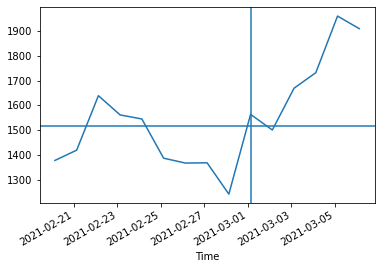

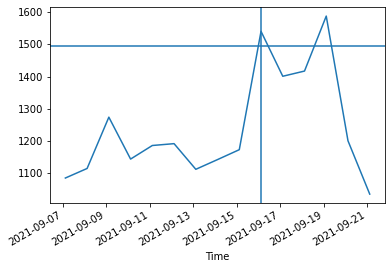

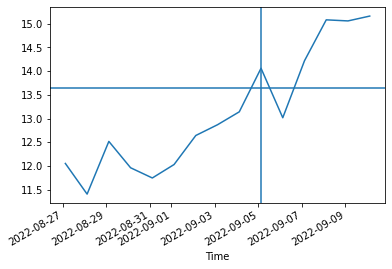

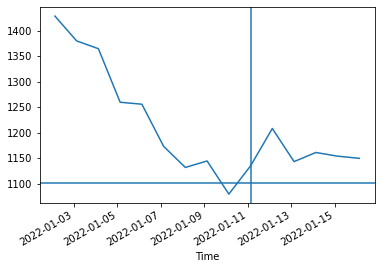

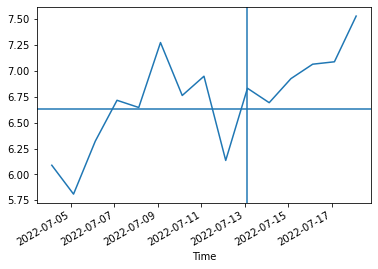

In [55]:
import matplotlib.pyplot as plt

res = y_test.to_frame("test")
res['predict'] = predict
res['symbol'] = data_set.loc[res.index, "symbol"]
res['pump_date'] = data_set.loc[res.index, "pump_date"]
res['data_type'] = data_set.loc[res.index, "data_type"]

for ind, row in res[(res["test"] != res['predict']) & (res["test"] == 0)].sample(5).iterrows():
    
    sample = results[results["Symbol"] == row['symbol']]

    sample.loc[:, ["High", "Low", "Close", "Open"]] = sample.loc[:, ["High", "Low", "Close", "Open"]].apply(normalize_prices)
    sample.loc[:, "cum_prod"] = sample["Close"].pct_change().add(1).rolling(window=roll_window).apply(np.prod).subtract(1).multiply(100).values
    pump = sample.loc[:(row["pump_date"]) + pd.Timedelta(days=5)].iloc[-15:]
    pump['Close'].plot()
    plt.axvline(x=(row["pump_date"]))
    plt.axhline(y=(sample.loc[row["pump_date"], "Close"]*0.97))
    plt.show()
    

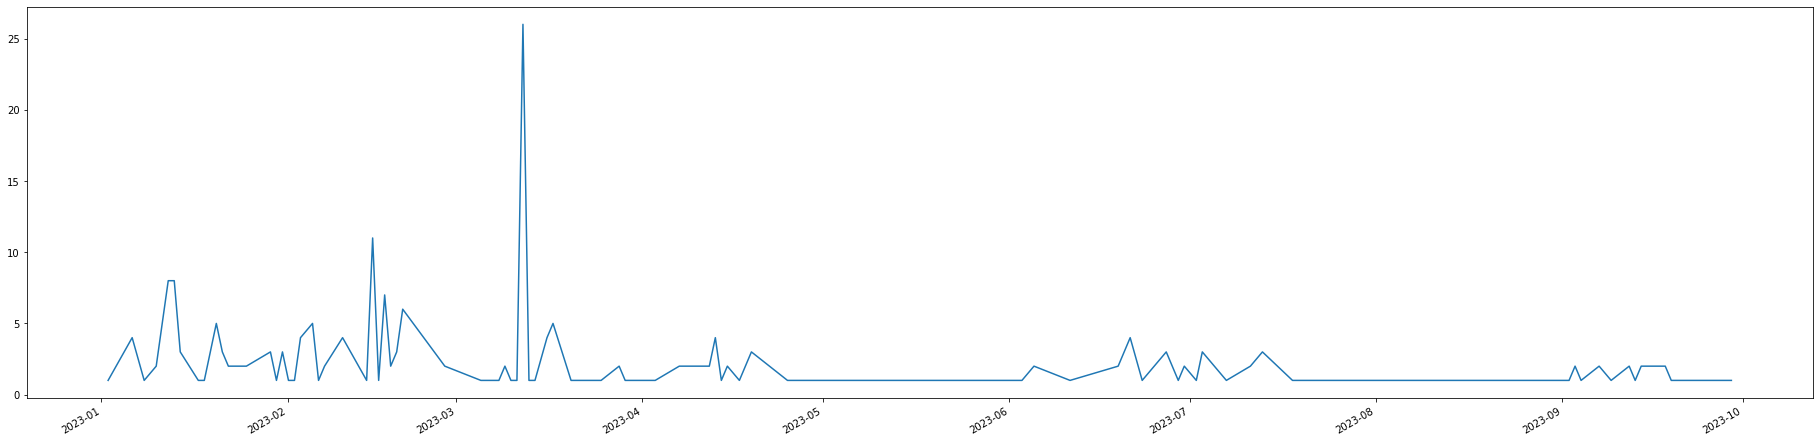

In [54]:
plt.rcParams["figure.figsize"] = (32,8)
data_set[data_set['class'] == 1]["pump_date"].value_counts().loc["2023-01-01":].sort_index(ascending=False).plot()
plt.show()

In [710]:
data_set[data_set['class'] == 1]["pump_date"].value_counts().loc["2023-01-01":].sort_index(ascending=False)

2023-10-06 03:00:00+03:00     2
2023-10-04 03:00:00+03:00     1
2023-10-01 03:00:00+03:00     1
2023-09-30 03:00:00+03:00     2
2023-09-29 03:00:00+03:00     1
2023-09-28 03:00:00+03:00     1
2023-09-27 03:00:00+03:00     2
2023-09-26 03:00:00+03:00     1
2023-09-25 03:00:00+03:00     1
2023-09-24 03:00:00+03:00     1
2023-09-23 03:00:00+03:00     1
2023-09-22 03:00:00+03:00     2
2023-09-21 03:00:00+03:00     1
2023-09-20 03:00:00+03:00     1
2023-09-19 03:00:00+03:00     3
2023-09-18 03:00:00+03:00     2
2023-09-17 03:00:00+03:00     3
2023-09-16 03:00:00+03:00     1
2023-09-15 03:00:00+03:00     6
2023-09-14 03:00:00+03:00     1
2023-09-13 03:00:00+03:00     2
2023-09-12 03:00:00+03:00     3
2023-09-11 03:00:00+03:00     2
2023-09-08 03:00:00+03:00     2
2023-09-07 03:00:00+03:00     3
2023-09-06 03:00:00+03:00     4
2023-09-05 03:00:00+03:00     3
2023-09-04 03:00:00+03:00     6
2023-09-03 03:00:00+03:00     2
2023-09-02 03:00:00+03:00     4
2023-09-01 03:00:00+03:00     3
2023-08-

In [61]:
df = res[(res["test"] != res['predict']) & (res["test"] == 0)]
df["data_type"].value_counts()

>5>0<15    148
>5<0        65
Name: data_type, dtype: int64

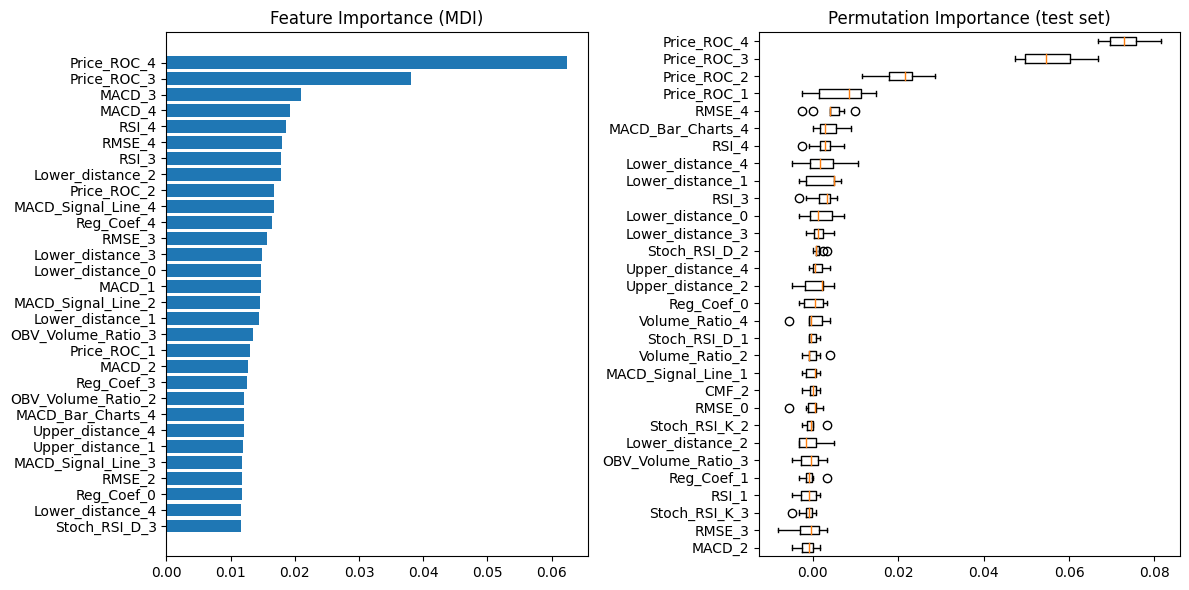

In [43]:
from sklearn.inspection import permutation_importance

feature_names = data_set.drop(["symbol", "pump_date", "class", "data_type"], axis=1).columns.values

feature_importance = model.best_estimator_.feature_importances_
sorted_idx = np.argsort(feature_importance)[-30:]
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, feature_names[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    model.best_estimator_, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()[-30:]
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=feature_names[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

# Изменение кэфа

In [724]:
sorted_idx

array([21, 17, 22, 34, 32, 26,  9, 19,  7,  4,  2, 20, 23, 56, 47,  8, 14,
       24, 44, 38, 11,  5, 10, 37, 48, 43, 15, 51, 28, 55,  6, 27, 49, 33,
       18,  3, 50, 54, 12, 53, 35, 25, 13, 46, 39, 16, 52, 59, 58, 40, 36,
       41], dtype=int64)

In [676]:
row["pump_date"]

Timestamp('2021-11-08 03:00:00+0300', tz='Europe/Moscow')

In [603]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [490]:
sample["cum_yield"].rolling(window=candles_for_lin_reg).apply(lambda x: print(x))

Time
2018-01-02 03:00:00+03:00    100.000000
2018-01-03 03:00:00+03:00    101.665405
2018-01-04 03:00:00+03:00    102.619606
2018-01-05 03:00:00+03:00    115.572490
2018-01-06 03:00:00+03:00    116.317970
2018-01-07 03:00:00+03:00    110.050487
2018-01-08 03:00:00+03:00    101.549767
2018-01-09 03:00:00+03:00     98.125329
2018-01-10 03:00:00+03:00    101.580772
2018-01-11 03:00:00+03:00     90.212475
2018-01-12 03:00:00+03:00     93.627986
2018-01-13 03:00:00+03:00     96.830620
2018-01-14 03:00:00+03:00     91.822072
2018-01-15 03:00:00+03:00     92.264589
2018-01-16 03:00:00+03:00     74.275423
2018-01-17 03:00:00+03:00     74.880461
2018-01-18 03:00:00+03:00     74.697702
2018-01-19 03:00:00+03:00     78.193485
2018-01-20 03:00:00+03:00     87.222106
2018-01-21 03:00:00+03:00     78.568406
2018-01-22 03:00:00+03:00     73.321767
2018-01-23 03:00:00+03:00     73.588409
2018-01-24 03:00:00+03:00     77.341771
2018-01-25 03:00:00+03:00     76.151184
2018-01-26 03:00:00+03:00     75.56

TypeError: must be real number, not NoneType

In [492]:
sample

,Open,High,Low,Close,Volume,Symbol,cum_yield
Time,,,,,,,
2018-01-02 03:00:00+03:00,13382.16,15473.49,12890.02,14675.11,20078.092111,BTCUSDT,100.000000
2018-01-03 03:00:00+03:00,14690.0,15307.56,14150.0,14919.51,15905.667639,BTCUSDT,101.665405
2018-01-04 03:00:00+03:00,14919.51,15280.0,13918.04,15059.54,21329.649574,BTCUSDT,102.619606
2018-01-05 03:00:00+03:00,15059.56,17176.24,14600.0,16960.39,23251.491125,BTCUSDT,115.572490
2018-01-06 03:00:00+03:00,16960.39,17143.13,16011.21,17069.79,18571.457508,BTCUSDT,116.317970
...,...,...,...,...,...,...,...
2023-10-03 03:00:00+03:00,27494.51,27676.52,27160.5,27426.46,28928.96555,BTCUSDT,186.891001
2023-10-04 03:00:00+03:00,27426.45,27839.72,27202.0,27778.57,29816.142,BTCUSDT,189.290370
2023-10-05 03:00:00+03:00,27778.57,28120.39,27352.0,27410.39,30681.49619,BTCUSDT,186.781496


In [442]:
data_set = data_set[data_set["class"] == 1]

In [392]:
for date in cum_prod.index:
    pump_date = date - pd.Timedelta(days=roll_window-1)
    observations = sample.loc[:date].iloc[-candles_for_lin_reg:]
    
    yld = [100]
    for i in observations["Close"].pct_change().iloc[1:]:
        yld.append(yld[-1] * (i + 1))

    observations["cum_yield"] = yld
    
    reg_coef, rmse = get_linear_features(observations)

In [732]:
sample["Close"].pct_change()

Time
2020-07-06 03:00:00+03:00         NaN
2020-07-07 03:00:00+03:00   -0.030887
2020-07-08 03:00:00+03:00    0.013304
2020-07-09 03:00:00+03:00    0.076612
2020-07-10 03:00:00+03:00   -0.014339
                               ...   
2023-10-03 03:00:00+03:00   -0.053021
2023-10-04 03:00:00+03:00    0.045573
2023-10-05 03:00:00+03:00   -0.026152
2023-10-06 03:00:00+03:00    0.044757
2023-10-07 03:00:00+03:00   -0.015912
Name: Close, Length: 1189, dtype: float64

In [441]:
cum_prod.sample(frac=1).head(10)

,Open,High,Low,Close,Volume,Symbol,cum_prod,time_delta
Time,,,,,,,,
2020-10-09 03:00:00+03:00,10925.44,11104.64,10829.0,11050.64,48240.073237,BTCUSDT,3.602437,1.0
2021-10-22 03:00:00+03:00,62193.15,63732.39,60000.0,60688.22,52119.35886,BTCUSDT,-8.050116,1.0
2018-11-11 03:00:00+03:00,6435.16,6462.14,6355.0,6449.81,8213.507117,BTCUSDT,0.464487,1.0
2021-11-05 03:00:00+03:00,61395.01,62595.72,60721.0,60937.12,31604.48749,BTCUSDT,-3.115214,1.0
2022-09-12 03:00:00+03:00,21826.87,22488.0,21538.51,22395.74,395395.61828,BTCUSDT,3.452459,1.0
2022-09-29 03:00:00+03:00,19412.82,19645.52,18843.01,19591.51,406424.93256,BTCUSDT,2.685552,1.0
2020-04-08 03:00:00+03:00,7197.32,7420.0,7150.0,7361.28,76059.145838,BTCUSDT,0.428110,1.0
2022-12-30 03:00:00+03:00,16633.47,16677.35,16333.0,16607.48,164916.31174,BTCUSDT,0.363624,1.0
2018-05-19 03:00:00+03:00,8238.01,8390.8,8095.73,8233.49,17193.424276,BTCUSDT,2.387999,1.0


In [41]:
from source.prices_source.binance_prices import get_candles_spot_binance
from source.utils import normalize_prices

from source.features.super_trend import calculate_supertrend
from source.features.macd import calculate_macd
from source.features.rsi import calculate_rsi
from source.features.obv import calculate_obv_to_volume_ratio
from source.features.bollinger_bands import distance_between_bb_bands
from source.features.chaikin_money_flow import calculate_cmf
from source.features.rate_of_change import calculate_price_rate_of_change, calculate_volume_rate_of_change
from source.features.volume_ratio import calculate_volume_ratio
from source.features.stoch_rsi import calculate_stoch_rsi
from source.features.linear_regression import calculate_trailing_linear_reg_params


features = {
    "calculate_supertrend": [["SuperTrend"], {"vol_func": "atr", "lookback": 20, "multiplier": 2.5}],
    "calculate_macd": [["MACD_Signal_Line", "MACD", "MACD_Bar_Charts"], {"short_period": 12, "long_period": 26, "smoothing_period": 9}],
    "calculate_rsi": [["RSI"], {"period": 20, "ema": True}],
    "calculate_obv_to_volume_ratio": [["OBV_Volume_Ratio"], {}],
    "distance_between_bb_bands": [["Upper_distance", "Lower_distance"], {"period": 20, "multiplier": 2.5, "ema": 2.5, "normalize": True}],
    "calculate_cmf": [["CMF"], {"period": 20}],
    "calculate_price_rate_of_change": [["Price_ROC"], {}],
    "calculate_volume_rate_of_change": [["Volume_ROC"], {}],
    "calculate_volume_ratio": [["Volume_Ratio"], {"period": 20, "ema": True}],
    "calculate_stoch_rsi": [["Stoch_RSI_K", "Stoch_RSI_D"], {"rsi_period": 20, "k_period": 20, "smooth_k": 5, "smooth_k": 5, "ema": True}],
    "calculate_trailing_linear_reg_params": [["Reg_Coef", "RMSE"], {"period": 25, "col_name": "cum_prod"}]
}

feature_cols = sum(list(map(lambda x: x[0], features.values())), [])

strategy_params = {
    "last_features_window": 7,
    "time_between_pump": 30,
    "candles_for_lin_reg": 25,
    "roll_window": 10, # candles
    "min_yield": -20, # %
    "max_yield": 20,
    "first_yield": 3
}


data_set = pd.DataFrame({})

symbols = results["Symbol"].unique()

for symbol in tqdm(symbols):
    
    # try:
    sample = results[results["Symbol"] == symbol]

    sample.loc[:, ["High", "Low", "Close", "Open"]] = sample.loc[:, ["High", "Low", "Close", "Open"]].apply(normalize_prices)
    sample = sample.iloc[1:]

    if len(sample) < strategy_params["time_between_pump"]:
        continue


    sample.loc[:, "cum_prod"] = sample["Close"].pct_change().add(1).rolling(window=strategy_params["roll_window"]).apply(np.prod).subtract(1).multiply(100).fillna(0).values
    sample.loc[:, "yield_at_pump"] = sample["Close"].pct_change().multiply(100).shift(strategy_params["roll_window"])


    for feature, values in features.items():
        eval(feature)(sample, **values[1])
    
    feature_df = sample[feature_cols].bfill()
    
    # Main observations
    outliers_values = sample[(sample["cum_prod"] >= strategy_params["max_yield"]) & (sample["yield_at_pump"] >= strategy_params["first_yield"])]
    
    # For diluting data
    other_values_first = sample[(sample["cum_prod"] < strategy_params["max_yield"]) & (sample["cum_prod"] > 0) & (sample["yield_at_pump"] >= strategy_params["first_yield"])]
    other_values_second = sample[(sample["cum_prod"] < 0) & (sample["yield_at_pump"] >= strategy_params["first_yield"])]
    other_values_third = sample[(sample["yield_at_pump"] < strategy_params["first_yield"])]


    if outliers_values.empty:
        continue

    outliers_values.loc[:, "time_delta"] = outliers_values.reset_index().Time.diff().apply(lambda x: x.days).fillna(10e5).values
    outliers_values = outliers_values[outliers_values["time_delta"] >= strategy_params["time_between_pump"]]

    for date in outliers_values.index:
        pump_date = date - pd.Timedelta(days=strategy_params["roll_window"])
        observations = sample.loc[:date].iloc[-strategy_params["candles_for_lin_reg"]:]

        observations.loc[:, "cum_yield"] = normalize_prices(observations.loc[:, "Close"])

        summary_dct = {
            'symbol': symbol,
            'pump_date': pump_date,
            'data_type': ">5>15",
            'class': 1
        }
        
        last_features = feature_df.loc[:pump_date].iloc[-5:]
        for name, values in last_features.items():
            for i, value in enumerate(values):
                summary_dct[name + "_" + str(i)] = value

        summary = pd.DataFrame(summary_dct, index=[len(data_set) + 1])

        data_set = pd.concat([data_set, summary])
    
    for sample_numb, data_name, other_values in [[4, ">5>0<15", other_values_first], [2, ">5<0", other_values_second], [2, "<0", other_values_third]]:
        for date in other_values.sample(frac=1).head(sample_numb).index:
            pump_date = date - pd.Timedelta(days=strategy_params["roll_window"])
            observations = sample.loc[:date].iloc[-strategy_params["candles_for_lin_reg"]:]

            observations.loc[:, "cum_yield"] = normalize_prices(observations.loc[:, "Close"])

            summary_dct = {
                'symbol': symbol,
                'pump_date': pump_date,
                'data_type': data_name,
                'class': 0
            }

            last_features = feature_df.loc[:pump_date].iloc[-5:]
            for name, values in last_features.items():
                for i, value in enumerate(values):
                    summary_dct[name + "_" + str(i)] = value

            summary = pd.DataFrame(summary_dct, index=[len(data_set) + 1])

            data_set = pd.concat([data_set, summary])
    
    print(np.where(symbols == symbol)[0][0])
    # except:
    #     continue

  0%|          | 0/478 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9
11
12
13
14
15
16
18
19
21
22
24
25
26
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
96
97
98
99
100
101
102
103
104
105
106
107
109
110
111
112
113
114
115
118
119
120
121
122
123
125
126
127
128
129
130
131
132
133
134
135
136
137
138
140
143
144
145
146
147
148
149
150
151
152
153
155
156
158
159
160
161
162
163
165
167
168
169
170
171
173
174
175
176
177
178
179
180
181
182
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
249
250
251
252
253
254
255
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
29

In [42]:
import xgboost as xgb

data_set = data_set.dropna()
data_set = data_set[np.all(data_set != np.inf, axis=1)]
feature_names = data_set.drop(["symbol", "pump_date", "class", "data_type"], axis=1).columns

X_train, X_test, y_train, y_test = train_test_split(data_set.loc[:, feature_names], data_set.loc[:, 'class'].astype('int'), 
                                                    test_size = 0.2, shuffle=True)



xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42) # squarederror

params = {
    "colsample_bytree": [0.7, 0.3],
    "gamma": [0, 0.5],
    "learning_rate": [0.1, 0.03, 0.3], # default 0.1 
    "max_depth": [2, 6], # default 3
    "n_estimators": [100, 300], # default 100
    "subsample": [0.6, 0.4]
}

kfold = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)

model = GridSearchCV(xgb_model, 
                     param_grid=params,
                     cv=kfold,
                     verbose=1,
                     n_jobs=6)


model.fit(X_train, y_train)


predict = model.best_estimator_.predict(X_test)
# predict_proba = random_forest_model.best_estimator_.predict_proba(X_test)

# rate, _ = optimal_threshold(predict_proba[:, 1])

# print(rate)
print(classification_report(y_test, predict))
print("accuracy: ", accuracy_score(y_test, predict))
print(confusion_matrix(y_test, predict))

Fitting 5 folds for each of 96 candidates, totalling 480 fits
              precision    recall  f1-score   support

           0       0.83      0.70      0.76       659
           1       0.71      0.83      0.77       568

    accuracy                           0.76      1227
   macro avg       0.77      0.77      0.76      1227
weighted avg       0.77      0.76      0.76      1227

accuracy:  0.7636511817440913
[[464 195]
 [ 95 473]]


In [46]:
dump(model, "good_xgb.joblib")

['good_xgb.joblib']

In [27]:
import xgboost as xgb
xgb.__version__

'2.0.0'

In [44]:
data_set['class'].value_counts()

class
0    3279
1    2852
Name: count, dtype: int64

In [22]:
np.where(symbols == symbol)[0][0]

98

In [39]:
list(symbols).index(symbol)

['volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em', 'volume_sma_em', 'volume_vpt', 'volume_vwap', 'volume_mfi', 'volume_nvi', 'volatility_bbw', 'volatility_bbp', 'volatility_bbhi', 'volatility_bbli', 'volatility_kcw', 'volatility_kcp', 'volatility_kchi', 'volatility_kcli', 'volatility_dcw', 'volatility_dcp', 'volatility_ui', 'trend_macd', 'trend_macd_diff', 'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_kst_diff', 'trend_stc', 'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_aroon_up', 'trend_aroon_down', 'trend_aroon_ind', 'trend_psar_up_indicator', 'trend_psar_down_indicator', 'momentum_rsi', 'momentum_stoch_rsi', 'momentum_stoch_rsi_k', 'momentum_stoch_rsi_d', 'momentum_tsi', 'momentum_uo', 'momentum_stoch', 'momentum_stoch_signal', 'momentum_roc', 'momentum_ppo', 'momentum_ppo_hist', 'momentum_pvo', 'momentum_pvo_signal', 'momentum_pvo_hist', 'others_dr']


In [19]:
data_set[data_set['symbol'] != symbol]

SyntaxError: unmatched ')' (2325094059.py, line 1)

In [49]:
sample.loc[:date + pd.Timedelta(days=3)].iloc[-candles_for_lin_reg:]

,Open,High,Low,Close,Volume,Symbol,cum_prod,yield_berfore_pump
Time,,,,,,,,
2020-12-17 03:00:00+03:00,159.432558,153.811454,164.701063,155.345752,184882.476748,BTCUSDT,17.351258,0.795356
2020-12-18 03:00:00+03:00,170.354786,150.484345,173.389956,157.459740,79646.134315,BTCUSDT,8.304789,9.827282
2020-12-19 03:00:00+03:00,172.673096,156.212141,176.493132,162.326620,86045.064677,BTCUSDT,4.493762,6.850735
2020-12-20 03:00:00+03:00,178.010127,157.010474,178.898093,159.831988,76690.145685,BTCUSDT,1.506574,1.360827
2020-12-21 03:00:00+03:00,175.274694,155.768156,169.239458,154.817988,88030.297243,BTCUSDT,-4.625632,3.090873
2020-12-22 03:00:00+03:00,169.777375,154.051219,173.416333,162.252889,87033.126160,BTCUSDT,1.514654,-1.536798
2020-12-23 03:00:00+03:00,177.929348,155.750254,175.329441,158.314043,119047.259733,BTCUSDT,2.258171,-3.137044
2020-12-24 03:00:00+03:00,173.607176,153.775457,176.131767,161.696914,69013.834252,BTCUSDT,-0.342660,4.802350
2020-12-25 03:00:00+03:00,177.318086,160.208589,181.796460,168.397170,79519.943569,BTCUSDT,6.369067,-2.427597


In [6]:
results = pd.read_csv(r"data\binance_data.csv", index_col=0, sep=",")
results.index = results.index.map(lambda x: pd.Timestamp(x, tz="Europe/Moscow"))

In [163]:
df = results[results["Symbol"] == "BTCUSDT"]

In [69]:
df["ema_no_adjust"] = df['Close'].ewm(span=5, adjust=False).mean().round(4)
df["ema_adjust"] = df['Close'].ewm(span=5, adjust=True).mean().round(4)
df["equal"] = df["ema_adjust"] == df["ema_no_adjust"]

In [87]:
df["Close_1"] = df["Close"].shift(1)

In [80]:
df.tail(10).Close.sort_index(ascending=False).pct_change()

Time
2023-10-07 03:00:00+03:00         NaN
2023-10-06 03:00:00+03:00    0.000293
2023-10-05 03:00:00+03:00   -0.018642
2023-10-04 03:00:00+03:00    0.013432
2023-10-03 03:00:00+03:00   -0.012676
2023-10-02 03:00:00+03:00    0.002481
2023-10-01 03:00:00+03:00    0.018115
2023-09-30 03:00:00+03:00   -0.036796
2023-09-29 03:00:00+03:00   -0.002062
2023-09-28 03:00:00+03:00    0.004253
Name: Close, dtype: float64

In [164]:
prices_df = df


[1, 2, 3, 4, 5, 6]

In [190]:
sum(map(lambda x: x[0], features.values()), [])

['SuperTrend',
 'MACD_Signal_Line',
 'MACD',
 'MACD_Bar_Charts',
 'RSI',
 'OBV',
 'Upper_distance',
 'Lower_distance',
 'CMF',
 'Price_ROC',
 'Volume_ROC',
 'Volume_Ratio',
 'Stoch_RSI_K',
 'Stoch_RSI_D',
 'Reg_Coef',
 'RMSE']

In [193]:
sum(list(map(lambda x: x[0], features.values())), [])

['SuperTrend',
 'MACD_Signal_Line',
 'MACD',
 'MACD_Bar_Charts',
 'RSI',
 'OBV',
 'Upper_distance',
 'Lower_distance',
 'CMF',
 'Price_ROC',
 'Volume_ROC',
 'Volume_Ratio',
 'Stoch_RSI_K',
 'Stoch_RSI_D',
 'Reg_Coef',
 'RMSE']

In [212]:
sum(a, [])

['SuperTrend',
 'MACD_Signal_Line',
 'MACD',
 'MACD_Bar_Charts',
 'RSI',
 'OBV',
 'Upper_distance',
 'Lower_distance',
 'CMF',
 'Price_ROC',
 'Volume_ROC',
 'Volume_Ratio',
 'Stoch_RSI_K',
 'Stoch_RSI_D',
 'Reg_Coef',
 'RMSE']

In [205]:
a = []

a += [1]

In [206]:
a

[1]

In [ ]:
[1, 2, 3]

In [161]:
prices_df["rmse"] = prices_df["rmse"].round(2)
prices_df.tail(50)

,Open,High,Low,Close,Volume,Symbol,ema_no_adjust,ema_adjust,equal,Close_1,OBV,reg_coef,rmse,reg_coef1,rmse1
Time,,,,,,,,,,,,,,,
2023-08-19 03:00:00+03:00,26054.00,26281.00,25801.09,26100.01,26160.75343,BTCUSDT,27066.4797,27066.4797,True,26054.00,0.273094,-79.370992,837.07,-79.370992,837.068922
2023-08-20 03:00:00+03:00,26100.01,26299.00,25971.05,26189.99,19056.91209,BTCUSDT,26774.3165,26774.3165,True,26100.01,0.275211,-100.584885,883.86,-100.584885,883.863234
2023-08-21 03:00:00+03:00,26190.00,26258.42,25812.00,26126.92,30267.24233,BTCUSDT,26558.5177,26558.5177,True,26189.99,0.271849,-121.240477,899.43,-121.240477,899.428939
2023-08-22 03:00:00+03:00,26126.92,26139.42,25300.00,26056.00,34247.06688,BTCUSDT,26391.0118,26391.0118,True,26126.92,0.268045,-139.255685,899.51,-139.255685,899.509675
2023-08-23 03:00:00+03:00,26055.99,26819.27,25812.82,26432.72,44023.69978,BTCUSDT,26404.9145,26404.9145,True,26056.00,0.272935,-150.899615,880.27,-150.899615,880.274402
2023-08-24 03:00:00+03:00,26432.71,26577.87,25864.00,26180.05,30205.22116,BTCUSDT,26329.9597,26329.9597,True,26432.72,0.269580,-163.347692,855.60,-163.347692,855.602124
2023-08-25 03:00:00+03:00,26180.05,26314.05,25777.15,26060.01,27753.33772,BTCUSDT,26239.9765,26239.9765,True,26180.05,0.266497,-175.006815,825.09,-175.006815,825.093420
2023-08-26 03:00:00+03:00,26060.00,26125.77,25985.92,26017.37,10022.22322,BTCUSDT,26165.7743,26165.7743,True,26060.01,0.265384,-179.881954,815.86,-179.881954,815.855153
2023-08-27 03:00:00+03:00,26017.38,26182.23,25966.11,26101.77,12099.64216,BTCUSDT,26144.4395,26144.4395,True,26017.37,0.266728,-186.340415,790.88,-186.340415,790.880777


In [141]:
prices_df = prices_df.drop(["reg_coef", "rmse"], axis=1)

In [ ]:
period = 25
col_name = "Close"

data = prices_df[col_name]

for i in range(len(data.iloc[period:])):
    
    prices_df.loc[:, ["reg_coef", "rmse"]] = get_simple_linear_regr_params(data.iloc[i : period + i])


In [ ]:
candles

{'candles': {'error': 'Error while acquiring data.'}}

In [ ]:
data = requests.get("https://iss.moex.com/iss/statistics/engines/stock/markets/currency/analytics/IMOEX.json", params={"limit": 100, "date": 10}).json()

In [316]:
candles

,Open,Close,High,Low,Volume
begin,,,,,
2023-10-10 00:00:00+03:00,590.52,589.79,590.81,589.76,8.912687e+09
2023-10-11 00:00:00+03:00,589.95,589.71,590.44,589.34,4.673899e+09
2023-10-12 00:00:00+03:00,589.98,593.26,596.12,589.93,1.480129e+10
2023-10-13 00:00:00+03:00,593.46,593.92,594.86,593.46,3.329016e+09
2023-10-16 00:00:00+03:00,594.45,595.37,596.50,594.45,4.485534e+09


In [78]:
from source.prices_source.binance_prices import get_candles_spot_binance
from source.utils import normalize_prices

from source.features.super_trend import calculate_supertrend
from source.features.macd import calculate_macd
from source.features.rsi import calculate_rsi
from source.features.obv import calculate_obv_to_volume_ratio
from source.features.bollinger_bands import distance_between_bb_bands
from source.features.chaikin_money_flow import calculate_cmf
from source.features.rate_of_change import calculate_price_rate_of_change, calculate_volume_rate_of_change
from source.features.volume_ratio import calculate_volume_ratio
from source.features.stoch_rsi import calculate_stoch_rsi
from source.features.linear_regression import calculate_trailing_linear_reg_params


features = {
    "calculate_supertrend": [["SuperTrend"], {"vol_func": "atr", "lookback": 20, "multiplier": 2.5}],
    "calculate_macd": [["MACD_Signal_Line", "MACD", "MACD_Bar_Charts"], {"short_period": 12, "long_period": 26, "smoothing_period": 9}],
    "calculate_rsi": [["RSI"], {"period": 20, "ema": True}],
    "calculate_obv_to_volume_ratio": [["OBV_Volume_Ratio"], {}],
    "distance_between_bb_bands": [["Upper_distance", "Lower_distance"], {"period": 20, "multiplier": 2.5, "ema": 2.5, "normalize": True}],
    "calculate_cmf": [["CMF"], {"period": 20}],
    "calculate_price_rate_of_change": [["Price_ROC"], {}],
    "calculate_volume_rate_of_change": [["Volume_ROC"], {}],
    "calculate_volume_ratio": [["Volume_Ratio"], {"period": 20, "ema": True}],
    "calculate_stoch_rsi": [["Stoch_RSI_K", "Stoch_RSI_D"], {"rsi_period": 20, "k_period": 20, "smooth_k": 5, "smooth_k": 5, "ema": True}],
    "calculate_trailing_linear_reg_params": [["Reg_Coef", "RMSE"], {"period": 25, "col_name": "cum_prod"}]
}

feature_cols = sum(list(map(lambda x: x[0], features.values())), [])

strategy_params = {
    "last_features_window": 5,
    "time_between_pump": 30,
    "candles_for_lin_reg": 25,
    "roll_window": 10, # candles
    "min_yield": -20, # %
    "max_yield": 20,
    "first_yield": 3
}


data_set = pd.DataFrame({})

results = moex_results

symbols = results["Symbol"].unique()

for symbol in tqdm(symbols):
    
    # try:
    sample = results[results["Symbol"] == symbol]

    sample.loc[:, ["High", "Low", "Close", "Open"]] = sample.loc[:, ["High", "Low", "Close", "Open"]].apply(normalize_prices)
    sample = sample.iloc[1:]

    if len(sample) < strategy_params["time_between_pump"]:
        continue

    sample["Close_ROC"] = sample["Close"].pct_change() * 100
    sample.loc[:, "cum_prod"] = sample["Close"].pct_change().add(1).rolling(window=strategy_params["roll_window"]).apply(np.prod).subtract(1).multiply(100).fillna(0).values
    sample.loc[:, "yield_at_pump"] = sample["Close"].pct_change().multiply(100).shift(strategy_params["roll_window"])


    for feature, values in features.items():
        eval(feature)(sample, **values[1])
    
    feature_df = sample[feature_cols].bfill()
    
    summary_dct = {}
    for ind in sample.index[strategy_params["last_features_window"]:]:
        summary_dct["Close_ROC"] = sample.loc[ind, "Close_ROC"]
        summary_dct["Symbol"] = symbol
        last_features = feature_df.loc[:ind].iloc[-strategy_params["last_features_window"]:]
        for name, values in last_features.items():
            for i, value in enumerate(values):
                summary_dct[name + "_" + str(i)] = value

        summary = pd.DataFrame(summary_dct, index=[ind])

        data_set = pd.concat([data_set, summary])
        
    break

  0%|          | 0/1 [00:00<?, ?it/s]

In [79]:
data_set = data_set[data_set["Close_ROC"] >= strategy_params["first_yield"]]

data_set = data_set.dropna()
data_set = data_set[np.all(data_set != np.inf, axis=1)]
feature_names = data_set.drop(["Close_ROC", "Symbol"], axis=1).columns

model = load("good_xgb.joblib")

predict = model.best_estimator_.predict(data_set.loc[:, feature_names])

data_set["Class"] = predict

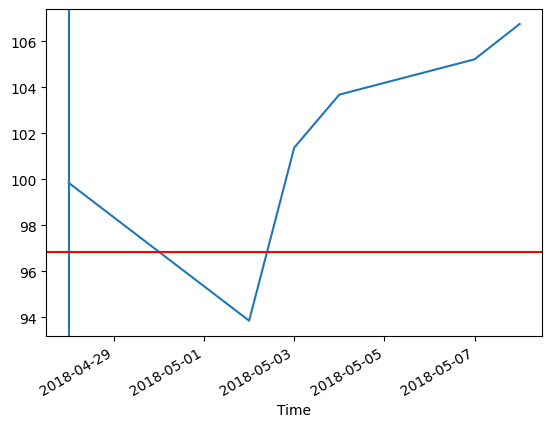

6.923076923076943


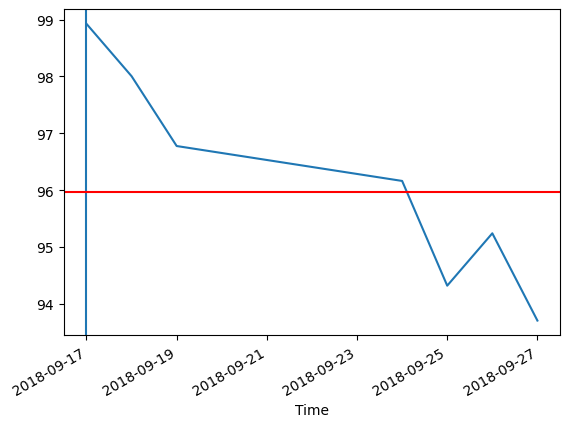

-5.279503105590056


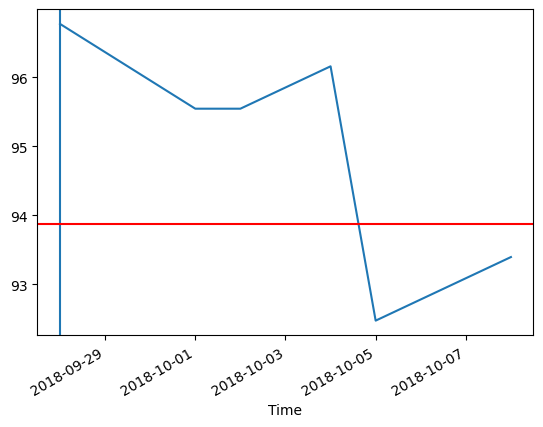

-3.492063492063513


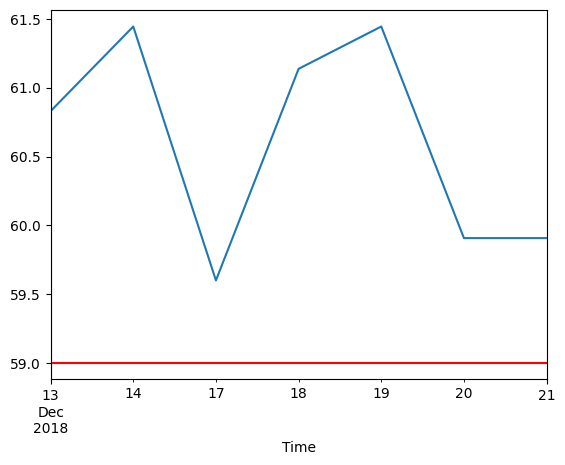

-1.515151515151525


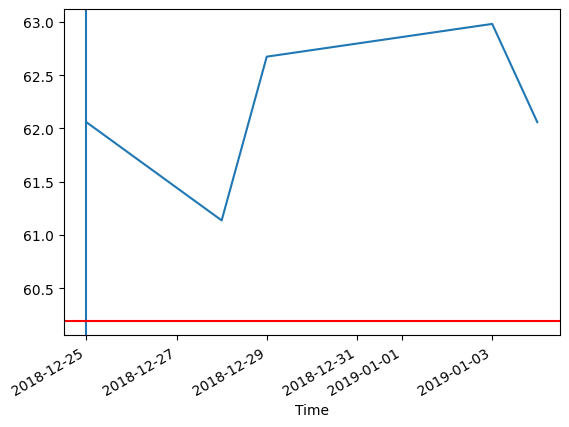

-1.1102230246251565e-14


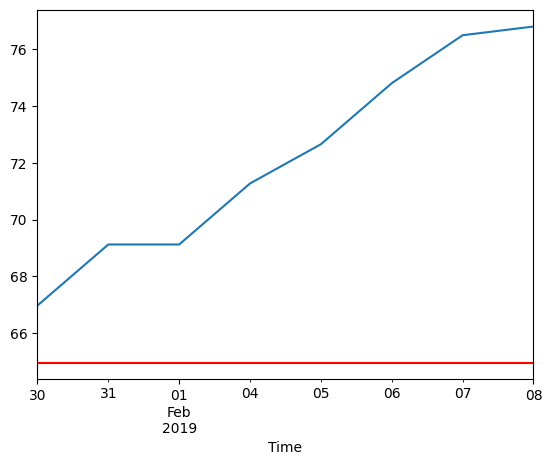

14.678899082568764


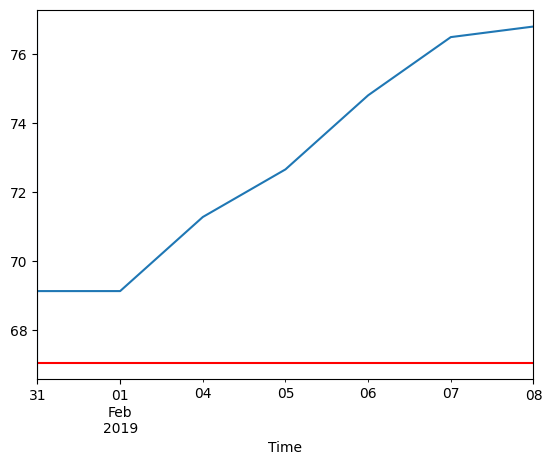

11.111111111111072


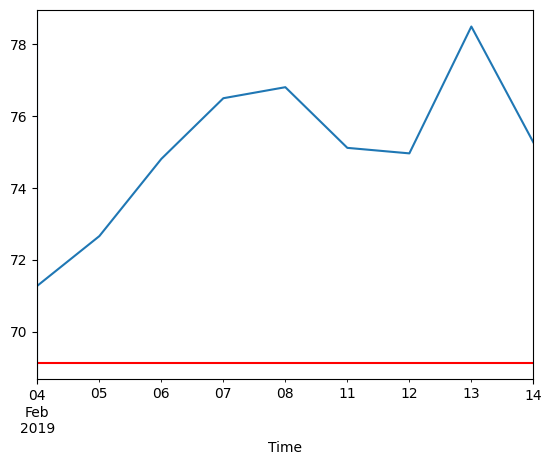

5.603448275862033


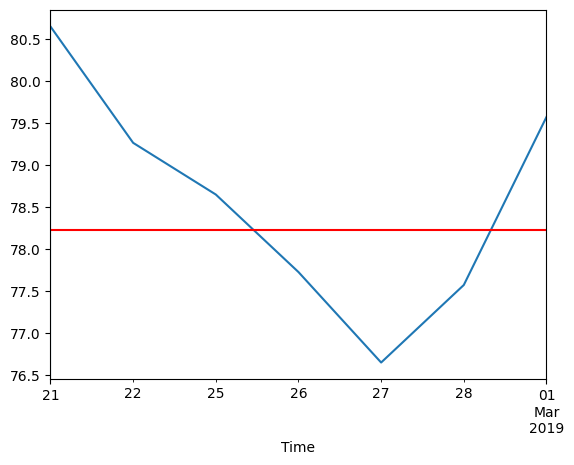

-1.3333333333333197


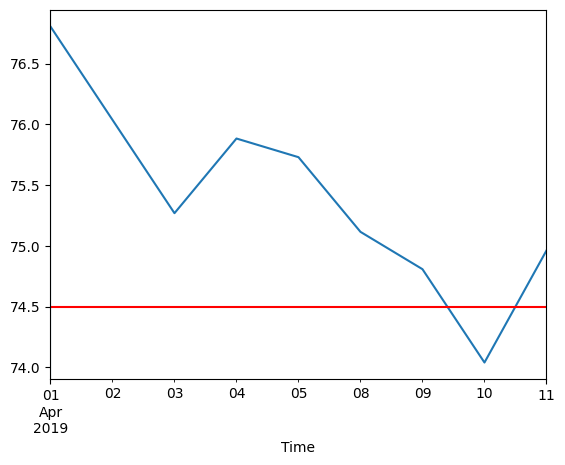

-2.4000000000000243


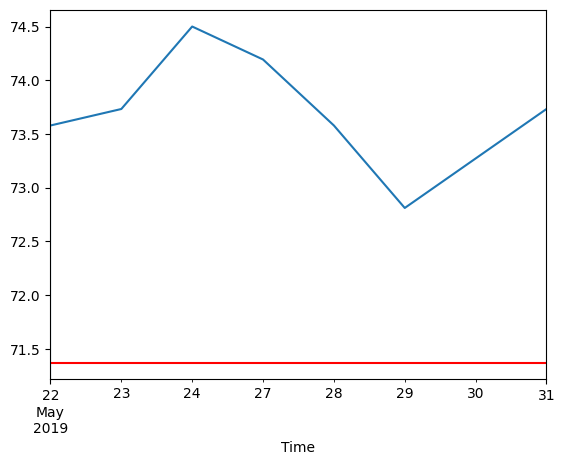

0.20876826722338038


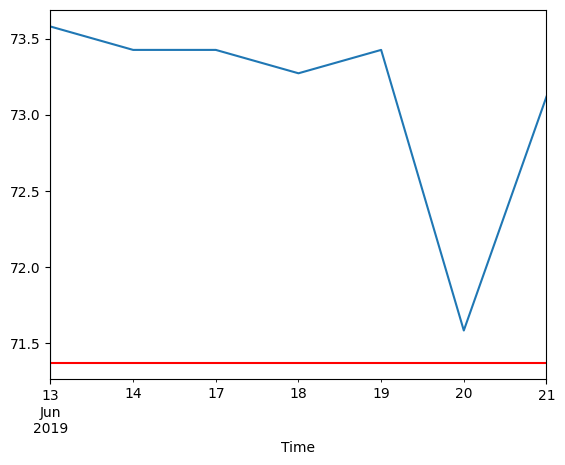

-0.6263048016701522


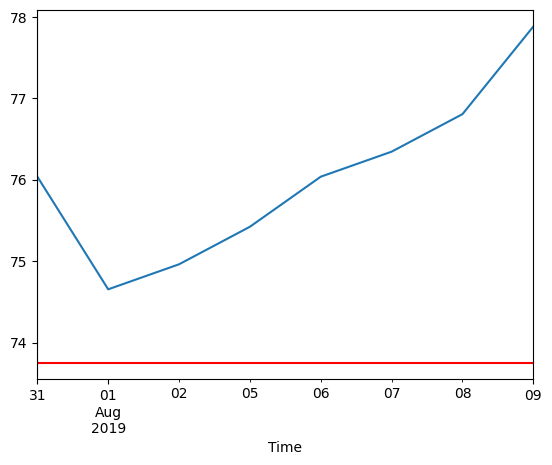

2.4242424242423732


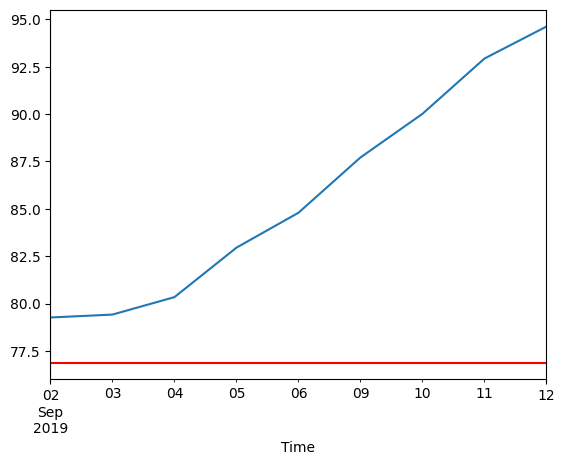

19.379844961240302


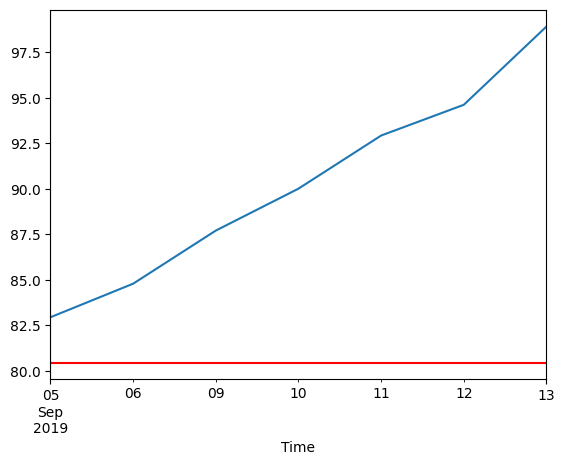

19.25925925925924


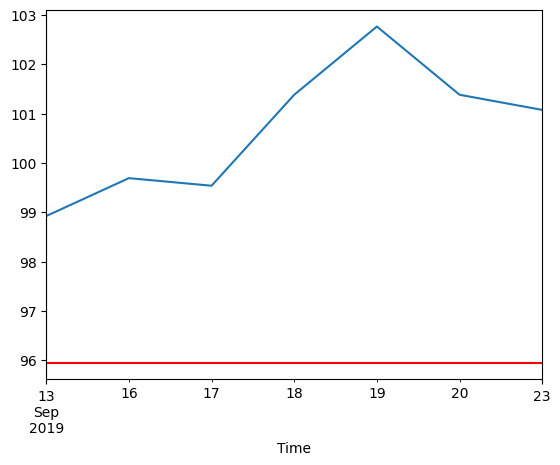

2.1739130434782705


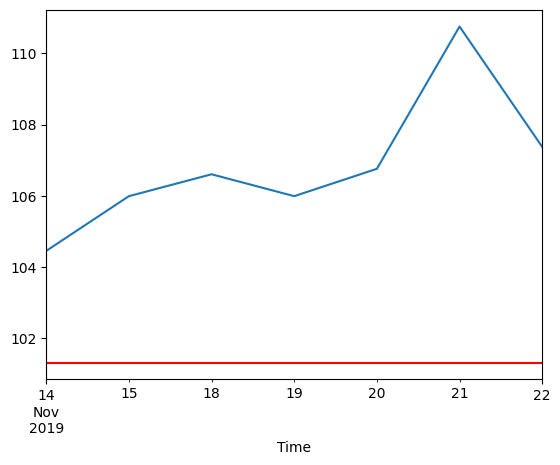

2.7941176470587914


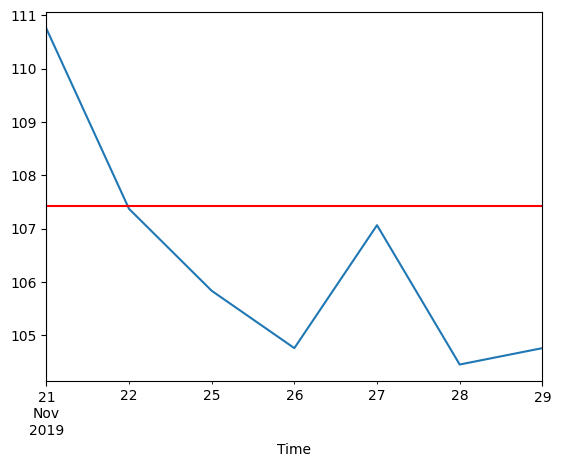

-5.409153952843271


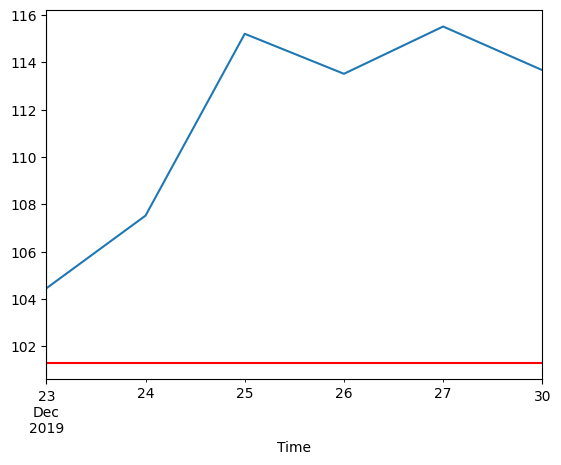

8.823529411764696


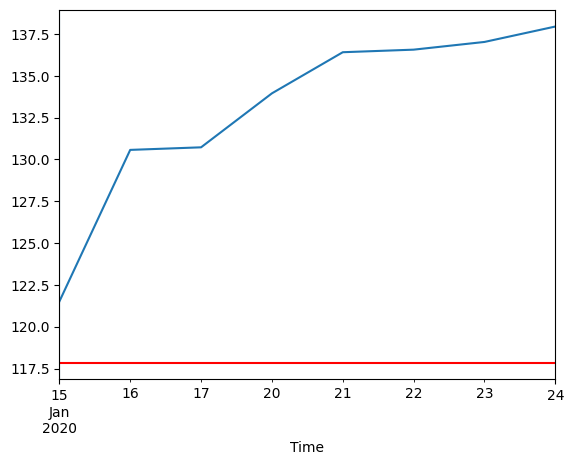

13.527180783817938


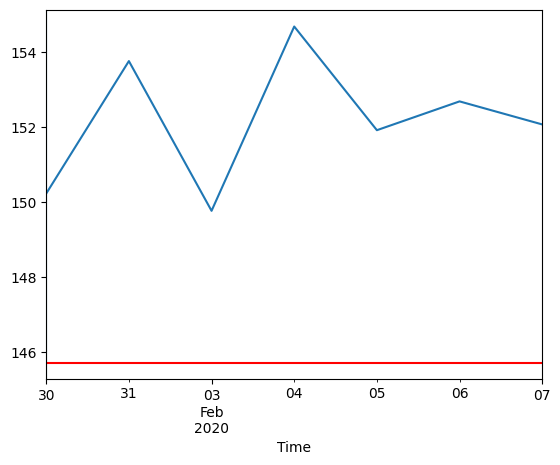

1.22699386503069


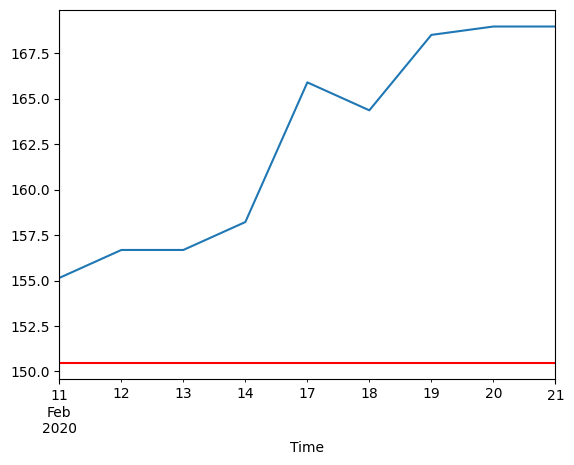

8.910891089108919


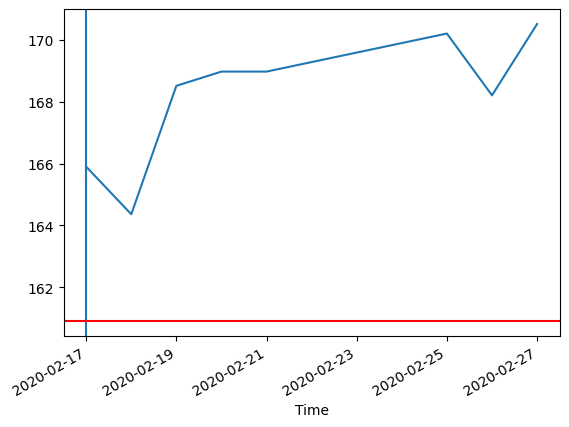

2.77777777777779


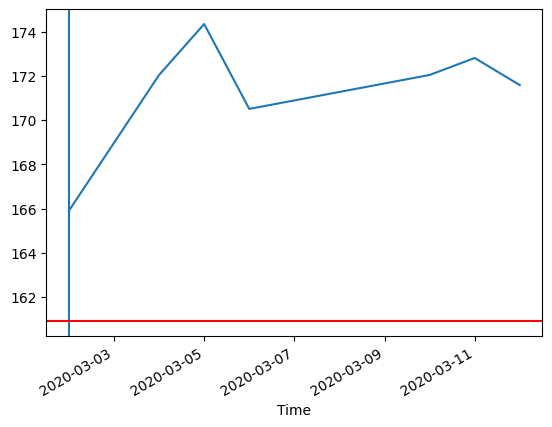

3.4259259259259434


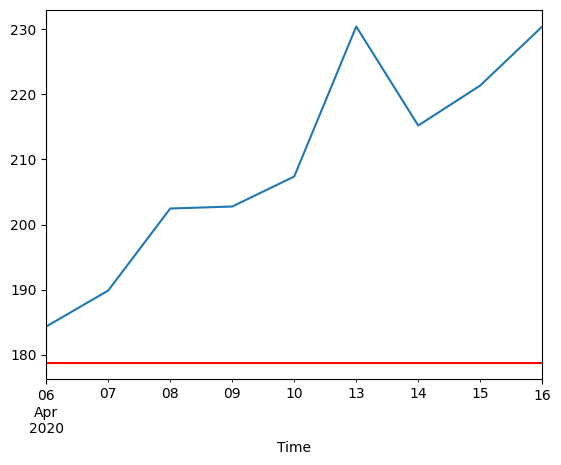

25.00000000000002


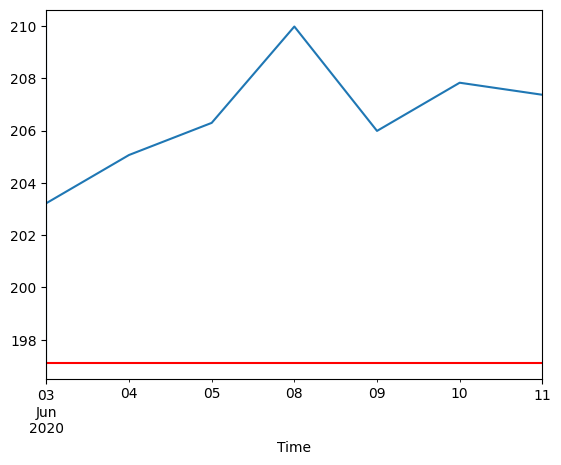

2.0408163265306145


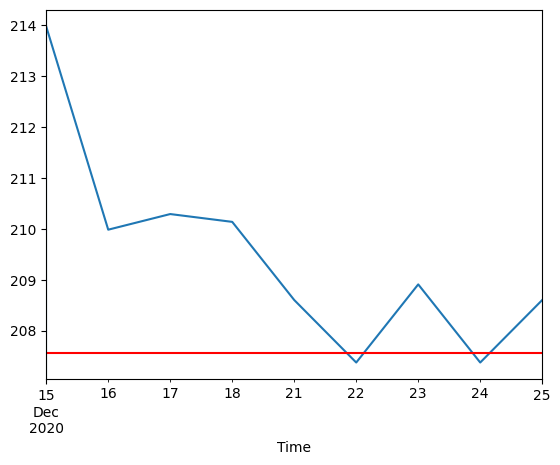

-2.5125628140703515


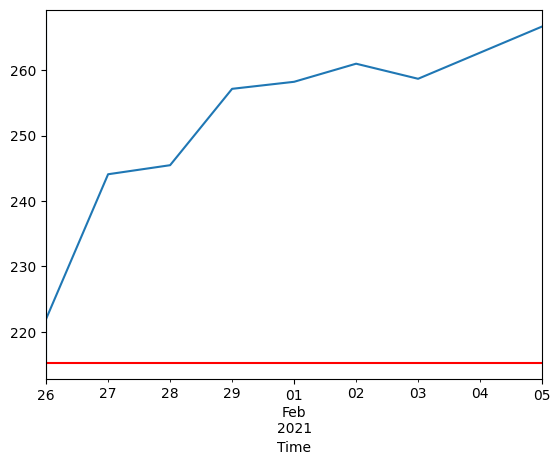

20.138408304498267


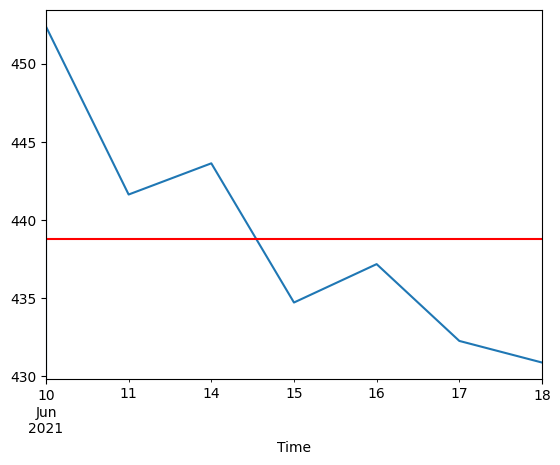

-4.753820033955858


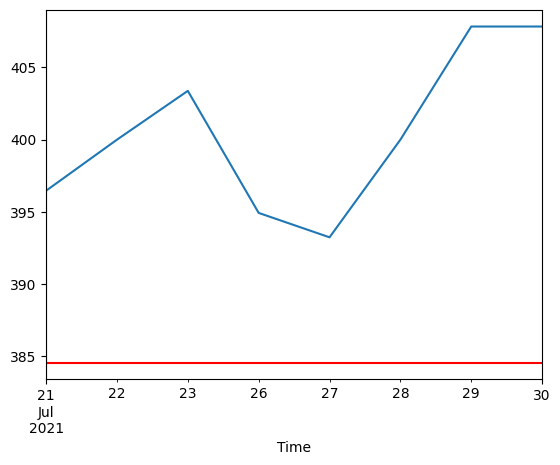

2.8671057729562355


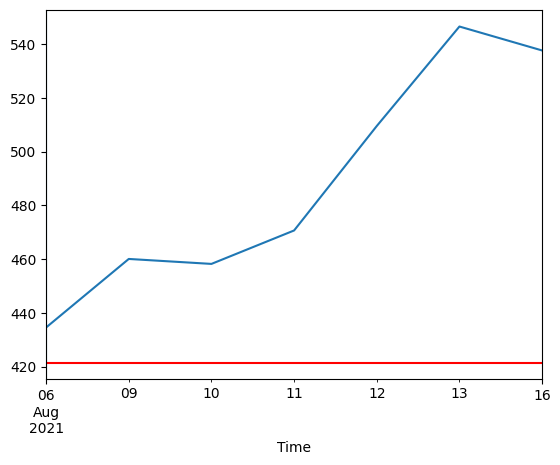

23.718628490632753


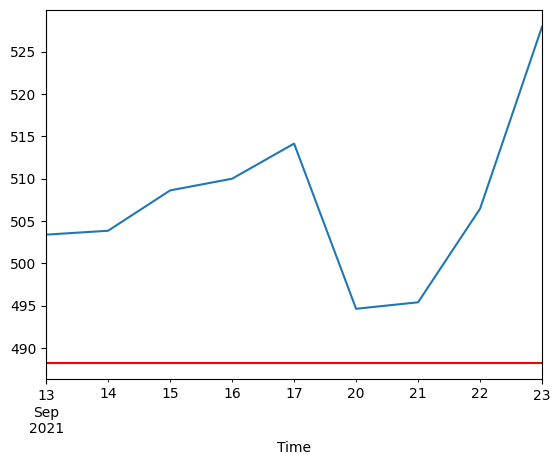

4.882514494964907


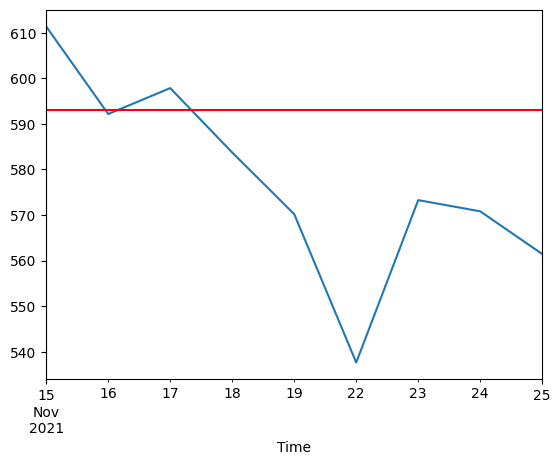

-8.165829145728686


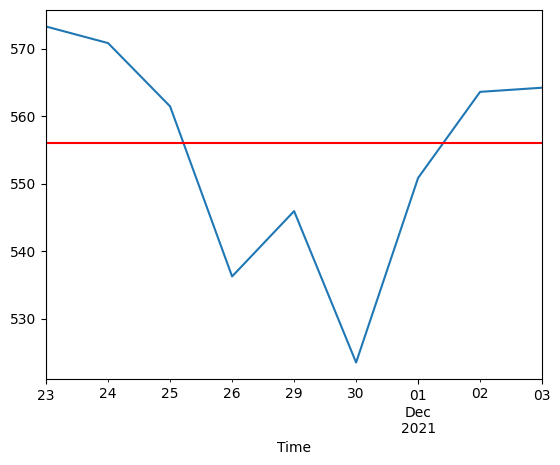

-1.5809217577706591


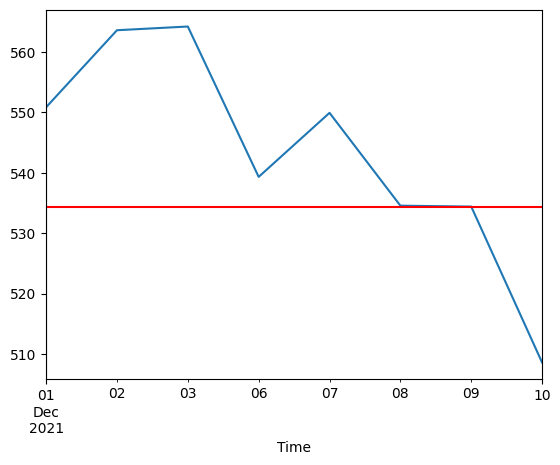

-7.6687116564417295


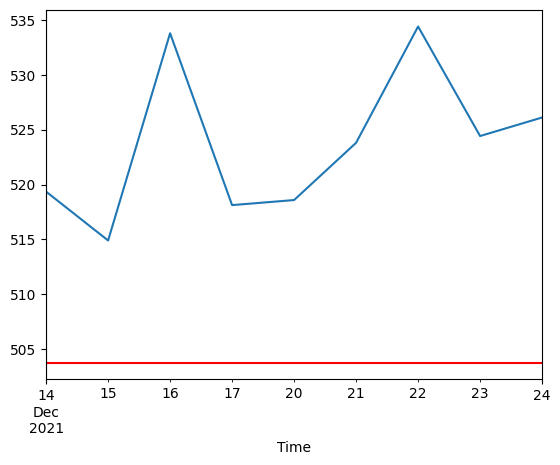

1.301390121265844


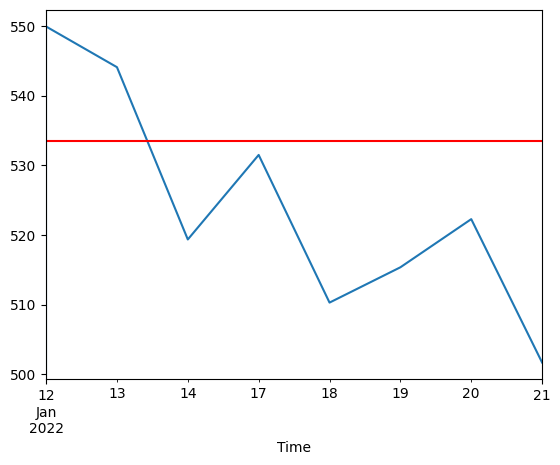

-8.770949720670417


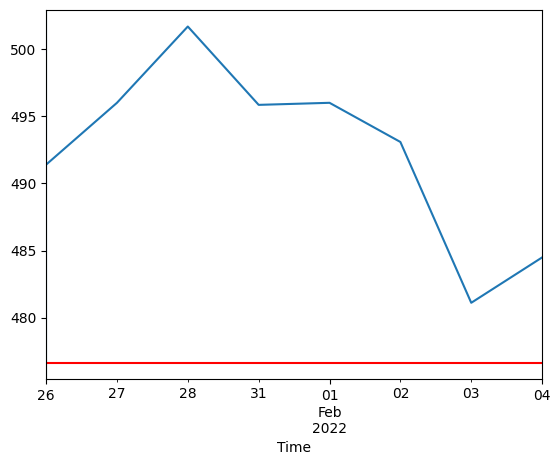

-1.4066895904970345


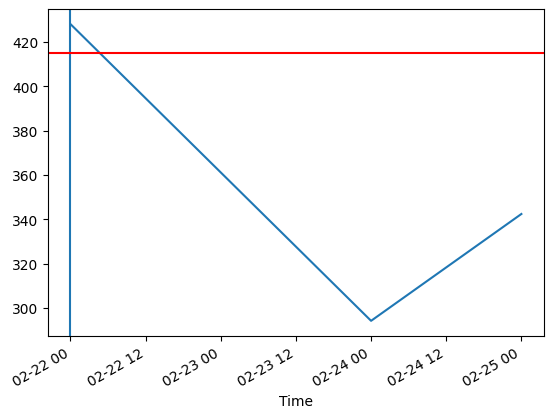

-20.021528525296016


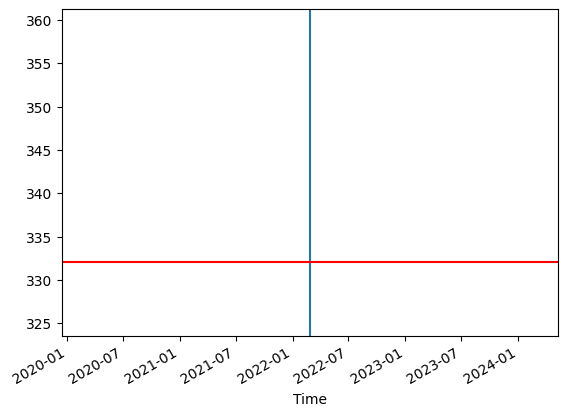

0.0


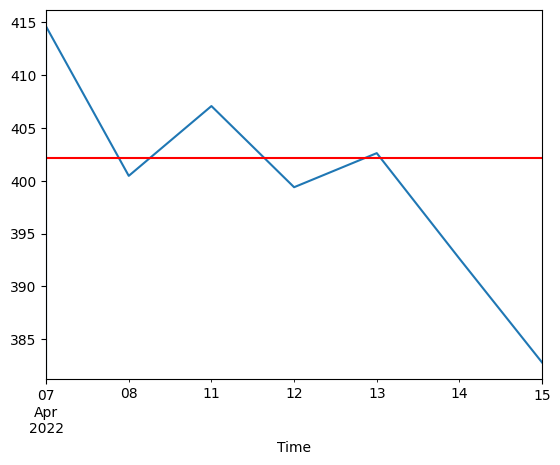

-7.669507224898108


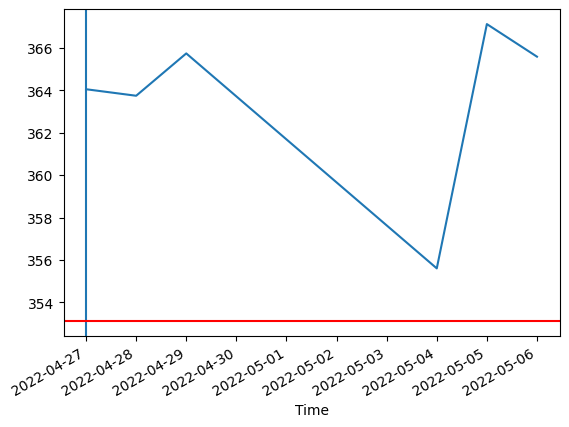

0.42194092827005925


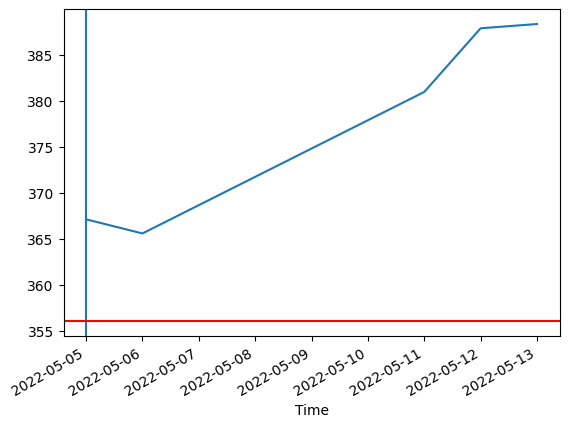

5.7740585774058495


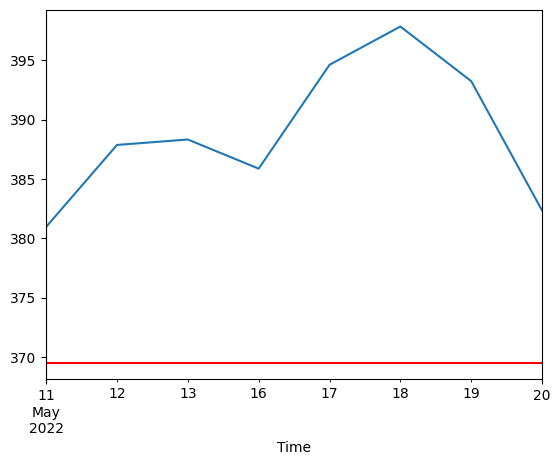

0.3629032258064102


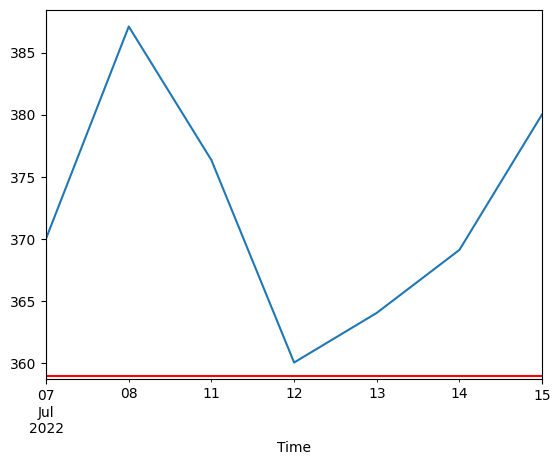

2.6982150269821537


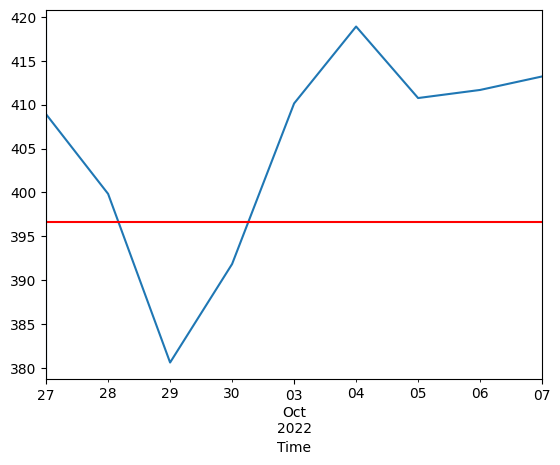

1.0518407212622316


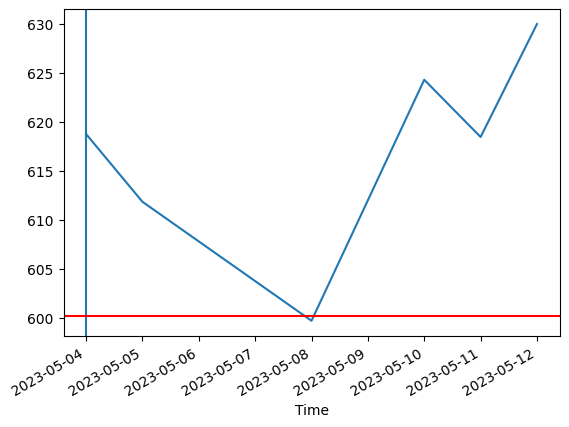

1.8123138033763642


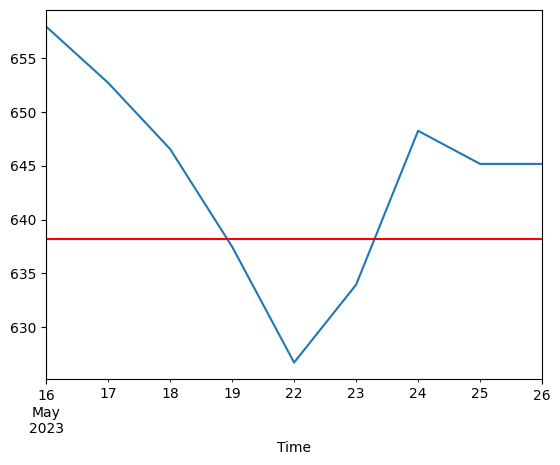

-1.9378939995330358


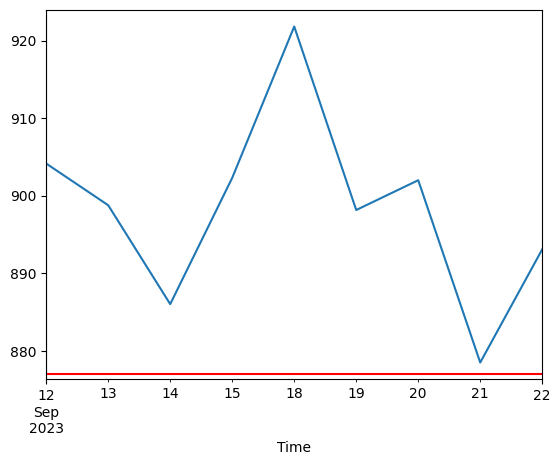

-1.2232415902140414


In [80]:
signals = data_set[data_set["Class"] == 1]
for ind in signals.index:
    yld = sample.loc[ind:ind+pd.Timedelta(days=10)]
    signals.loc[ind, "yield"] = (yld.iloc[-1]["Close"] / yld.iloc[0]["Close"] - 1) * 100
    signals.loc[ind, "min_point"] = yld["Close"].pct_change().add(1).apply(np.prod).subtract(1).min()*100
    
    yld['Close'].plot()
    plt.axvline(x=(ind))
    plt.axhline(y=(sample.loc[ind, "Close"]*0.97), color="red")
    plt.show()
    print(signals.loc[ind, "yield"])

In [81]:
signals["yield"].sum()

129.55194938277106

In [74]:
signals.reset_index()["index"].diff().apply(lambda x: x.days).describe()#.shift(1)

count     49.000000
mean      39.530612
std       38.979750
min        6.000000
25%       14.000000
50%       24.000000
75%       48.000000
max      181.000000
Name: index, dtype: float64

In [65]:
signals[signals['min_point']  > -5]["yield"]

2018-02-16 00:00:00+03:00    -2.790698
2018-03-01 00:00:00+03:00    -4.761905
2018-03-26 00:00:00+03:00    -2.185792
2018-04-18 00:00:00+03:00     7.017544
2018-06-21 00:00:00+03:00    -0.523560
2018-06-28 00:00:00+03:00     4.040404
2018-07-20 00:00:00+03:00    -3.208556
2018-08-16 00:00:00+03:00    -3.846154
2018-09-14 00:00:00+03:00    -2.325581
2018-11-01 00:00:00+03:00    -4.156770
2019-02-04 00:00:00+03:00     4.941176
2019-02-11 00:00:00+03:00    -0.109890
2019-03-27 00:00:00+03:00     4.371002
2019-04-11 00:00:00+03:00    -4.517454
2019-05-15 00:00:00+03:00    -9.388840
2019-07-02 00:00:00+03:00    36.670072
2019-08-21 00:00:00+03:00     9.704641
2019-08-30 00:00:00+03:00     8.692308
2019-10-11 00:00:00+03:00    -3.626543
2019-10-24 00:00:00+03:00    -3.053435
2020-03-19 00:00:00+03:00    18.191161
2020-07-17 00:00:00+03:00    -4.425113
2020-09-04 00:00:00+03:00    18.832051
2020-11-05 00:00:00+03:00    13.566667
2020-12-15 00:00:00+03:00    -1.321244
2021-01-20 00:00:00+03:00

In [ ]:
import matplotlib.pyplot as plt

res = y_test.to_frame("test")
res['predict'] = predict
res['symbol'] = data_set.loc[res.index, "symbol"]
res['pump_date'] = data_set.loc[res.index, "pump_date"]
res['data_type'] = data_set.loc[res.index, "data_type"]

for ind, row in res[(res["test"] != res['predict']) & (res["test"] == 0)].sample(5).iterrows():
    
    sample = results[results["Symbol"] == row['symbol']]

    sample.loc[:, ["High", "Low", "Close", "Open"]] = sample.loc[:, ["High", "Low", "Close", "Open"]].apply(normalize_prices)
    sample.loc[:, "cum_prod"] = sample["Close"].pct_change().add(1).rolling(window=roll_window).apply(np.prod).subtract(1).multiply(100).values
    pump = sample.loc[:(row["pump_date"]) + pd.Timedelta(days=5)].iloc[-15:]
    pump['Close'].plot()
    plt.axvline(x=(row["pump_date"]))
    plt.axhline(y=(sample.loc[row["pump_date"], "Close"]*0.97))
    plt.show()